In [1]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

2024-10-08 11:42:18.301976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 11:42:18.302795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 11:42:18.305492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 11:42:18.315464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 11:42:18.332819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [3]:
risk = "hi_gauss_blob_risk_fun"

In [4]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 100
c = 50
k = 2
M = .1
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, geno = simulate_genos(G, L, c, k, M, HWE)

In [5]:
humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

In [6]:
true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(geno, humans)
#true_p2s['pop'] = humans['populations']
#true_q2s['pop'] = humans['populations']
#true_twopqs['pop'] = humans['populations']

# Check PCA

In [7]:
scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

In [9]:
PC_geno['populations'] = humans['populations']

In [10]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [f"pop {i+1}"]*c
populations = pd.DataFrame(labels_pop, columns=['populations'])

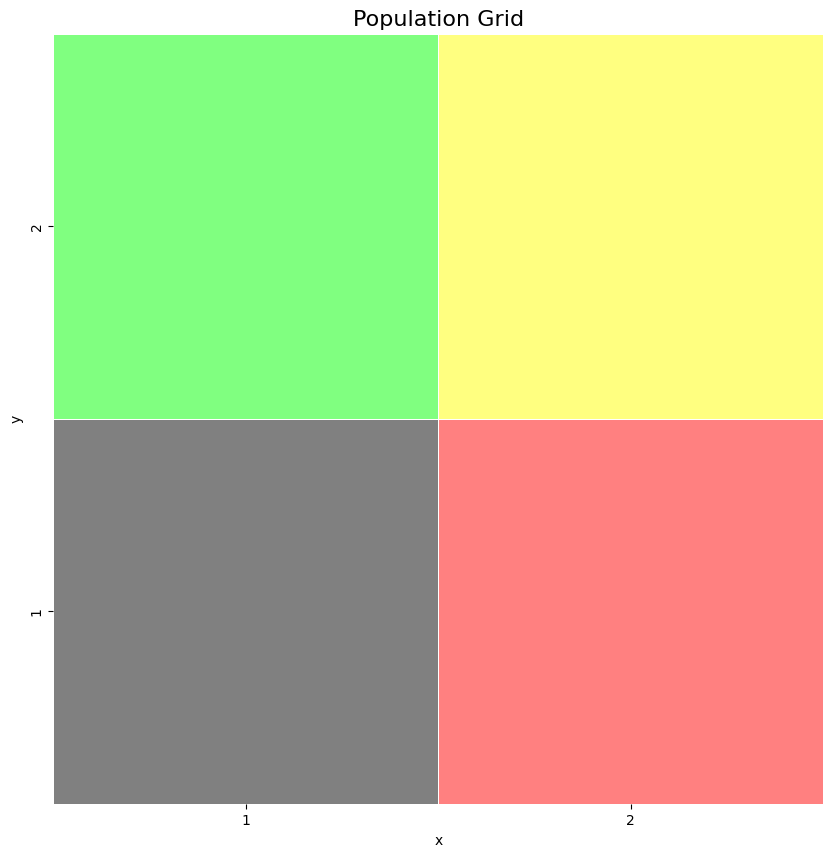

In [13]:
humans
humans['x'] = ((humans['populations'] - 1) % k) + 1
humans['y'] = ((humans['populations'] - 1) // k) + 1
humans['z'] = 0.5
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

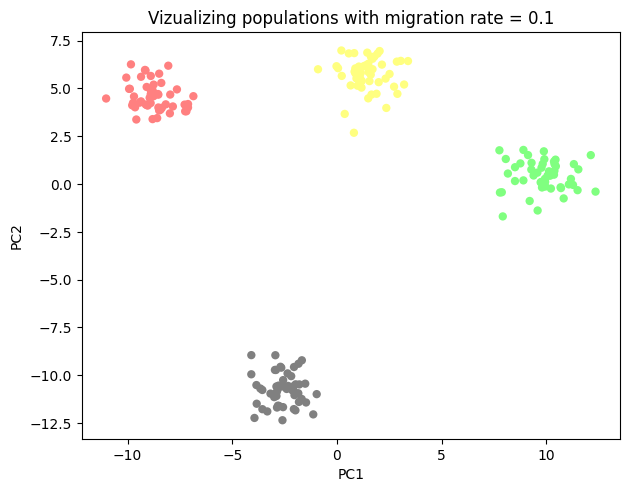

In [14]:
sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [15]:
# get correction

In [18]:
correction = pd.DataFrame()
for col in geno.columns:
    snp = geno[[col]]
    snp = pd.get_dummies(snp, columns=[col], dtype=int)
    correction[col] = list(geno[col]/(snp[f"{col}_-1.0"]*true_q2s[col] + snp[f"{col}_1.0"]*true_p2s[col] + snp[f"{col}_0.0"]*true_twopqs[col]))

In [19]:
correction

,CG3_AF_0.2775,CG5_AF_0.2725,CG6_AF_0.2625,CG15_AF_0.2075,CG25_AF_0.305,CG27_AF_0.2625,CG30_AF_0.4075,CG32_AF_0.3675,CG36_AF_0.2625,CG40_AF_0.215,...,VRG251_AF_0.045,VRG266_AF_0.045,VRG416_AF_0.0475,VRG441_AF_0.0475,VRG452_AF_0.0375,VRG456_AF_0.04,VRG464_AF_0.0375,VRG473_AF_0.05,VRG491_AF_0.0475,VRG500_AF_0.045
0,1.041667,2.941176,1.06383,1.041667,1.219512,-50.000000,-3.571429,-6.250000,1.063830,0.000000,...,1.063830,-50.000000,1.041667,1.086957,1.041667,1.063830,1.041667,1.041667,1.086957,1.086957
1,1.041667,0.000000,1.06383,1.041667,1.219512,1.136364,0.000000,0.000000,1.063830,5.555556,...,1.063830,1.136364,1.041667,-50.000000,1.041667,1.063830,1.041667,1.041667,1.086957,1.086957
2,0.000000,2.941176,1.06383,1.041667,1.219512,1.136364,0.000000,0.000000,1.063830,0.000000,...,1.063830,1.136364,1.041667,1.086957,1.041667,1.063830,1.041667,1.041667,1.086957,1.086957
3,1.041667,-5.555556,1.06383,1.041667,1.219512,1.136364,0.000000,3.571429,1.063830,-3.846154,...,1.063830,1.136364,1.041667,1.086957,1.041667,1.063830,1.041667,1.041667,1.086957,1.086957
4,1.041667,0.000000,1.06383,1.041667,1.219512,0.000000,5.555556,0.000000,1.063830,-3.846154,...,1.063830,1.136364,1.041667,1.086957,1.041667,1.063830,1.041667,1.041667,1.086957,1.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.846154,1.041667,0.00000,2.173913,-3.125000,0.000000,0.000000,3.571429,0.000000,1.041667,...,1.086957,1.041667,1.063830,0.000000,1.041667,1.041667,1.063830,1.086957,1.111111,1.086957
196,0.000000,1.041667,0.00000,0.000000,-3.125000,-4.166667,3.571429,-4.545455,0.000000,1.041667,...,1.086957,0.000000,1.063830,1.041667,1.041667,1.041667,1.063830,1.086957,1.111111,1.086957
197,3.846154,1.041667,-6.25000,-10.000000,4.545455,0.000000,0.000000,0.000000,-4.166667,1.041667,...,1.086957,1.041667,1.063830,1.041667,1.041667,1.041667,1.063830,1.086957,1.111111,1.086957
198,0.000000,1.041667,-6.25000,0.000000,0.000000,3.846154,3.571429,0.000000,0.000000,1.041667,...,0.000000,1.041667,-50.000000,1.041667,1.041667,1.041667,1.063830,1.086957,-50.000000,1.086957


In [20]:

# Check if any column contains NaN values
nan_columns = correction.isna().any()

# Check if any column contains inf values (both positive and negative inf)
inf_columns = correction.isin([np.inf, -np.inf]).any()

# Combine NaN and inf column checks into one dataframe for easier viewing
nan_inf_summary = pd.DataFrame({
    'NaN': nan_columns,
    'inf': inf_columns
})

# Show the columns that contain NaN or inf values
nan_inf_summary[nan_inf_summary['NaN'] | nan_inf_summary['inf']]

,NaN,inf


In [21]:
# Replace inf values (-inf and inf) with NaN first (to handle both at once)
correction.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now fill NaN values with the corresponding values from the 'complete' dataframe
correction.fillna(geno, inplace=True)


In [22]:
# calibrating
for col in correction.columns:
    X = correction[[col]]
    y = geno[col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[col]
    correction[col] = correction[col]*beta

In [23]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

In [24]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

<Axes: xlabel='x', ylabel='y'>

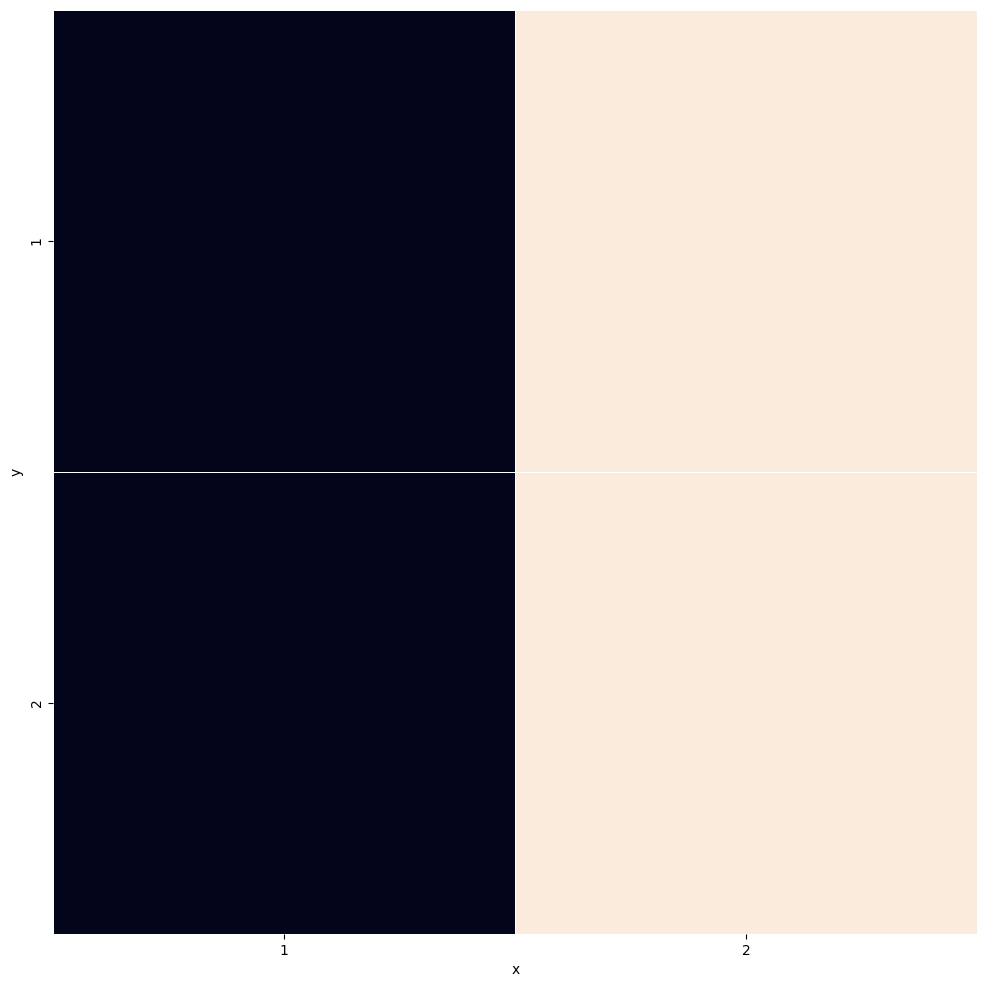

In [25]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [26]:
# check for one

In [27]:
to_check = list(geno.columns)[0]

In [28]:
humans['snp'] = geno[to_check]
humans['pop'] = PC_geno['populations']
humans['risk'] = humans[name_risk]

In [29]:
humans

,populations,x,y,z,x_temp,y_temp,hi_gauss_blob_risk,snp,pop,risk
0,1,1,1,0.5,0.5,0.5,0.735759,1.0,1,0.735759
1,1,1,1,0.5,0.5,0.5,0.735759,1.0,1,0.735759
2,1,1,1,0.5,0.5,0.5,0.735759,0.0,1,0.735759
3,1,1,1,0.5,0.5,0.5,0.735759,1.0,1,0.735759
4,1,1,1,0.5,0.5,0.5,0.735759,1.0,1,0.735759
...,...,...,...,...,...,...,...,...,...,...
195,4,2,2,0.5,1.0,1.0,0.013476,1.0,4,0.013476
196,4,2,2,0.5,1.0,1.0,0.013476,0.0,4,0.013476
197,4,2,2,0.5,1.0,1.0,0.013476,1.0,4,0.013476
198,4,2,2,0.5,1.0,1.0,0.013476,0.0,4,0.013476


In [30]:
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

0.32483349250959115


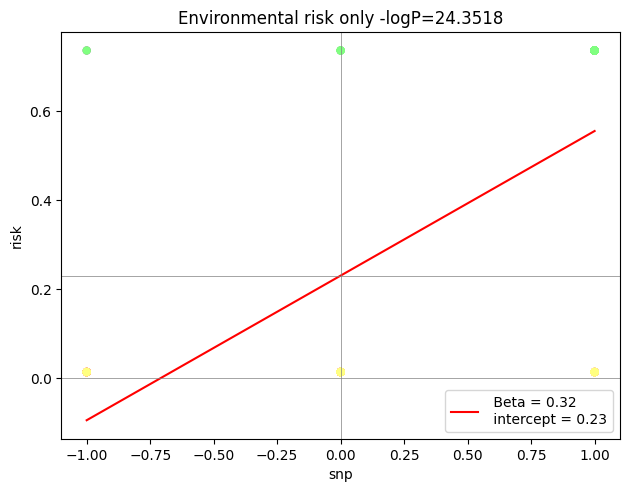

In [31]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [32]:
humans['corr'] = correction[to_check]

In [33]:
X = humans[['corr']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

1.3877787807814457e-16


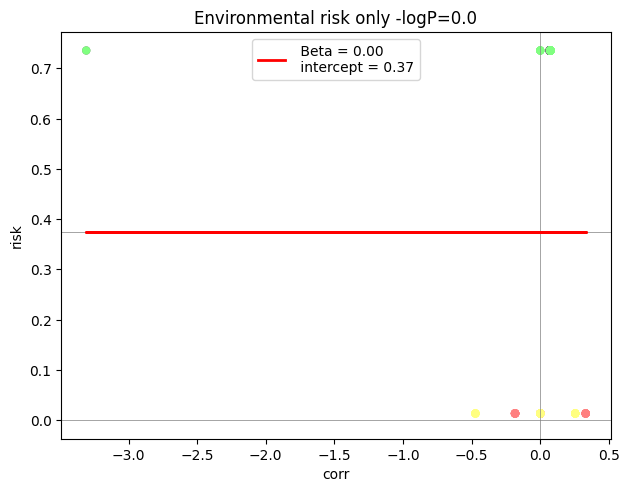

In [34]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='corr', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['corr'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [39]:
X = humans[['corr']]  # Predictor variable
y = humans['snp']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

1.0000000000000007


In [41]:
humans['majaf'] = majaf[to_check]
humans['minaf'] = minaf[to_check]
humans['hetaf'] = hetaf[to_check]
humans['p2_min_q2'] = humans['majaf'] - humans['minaf']

In [45]:
X = humans[['p2_min_q2']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['p2_min_q2']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['p2_min_q2']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

0.6838804696636027


In [47]:
X = humans[['corr']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

1.0408340855860843e-16


In [48]:
humans['snp'] - humans['corr']

0     -0.761266
1     -0.761266
2     -0.761266
3     -0.761266
4     -0.761266
         ...   
395    0.719748
396    0.719748
397    0.719748
398    0.719748
399    0.719748
Length: 400, dtype: float64